# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [2]:
 #!pip install numpy==1.26.4 pandas==2.2.2 seaborn==0.13.2 matplotlib==3.10.0 Pillow==11.1.0 tensorflow==2.18.0 keras==3.8.0 scikit-learn==1.6.1

In [3]:
# Import essential libraries

# Data Manipulation Libraries
import numpy as np
import pandas as pd
# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
# Data Loading Libraries
import zipfile
import os
# Preprocessing Libraries
from collections import Counter
# Train-Test Split Libraries
from sklearn.model_selection import train_test_split
# Encoding Categorical Labels Libraries
from tensorflow.keras.utils import to_categorical
# model building Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# Model Training Libraries
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Model Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Load the dataset.

In [4]:
# Define paths
zpath = "DataSet_waste_segregation/data.zip"
extract_path = "DataSet_waste_segregation"

# Check if the zip file exists
if os.path.exists(zpath):
    # Check if the 'data' directory already exists
    data_folder_path = os.path.join(extract_path, "data")
    if os.path.exists(data_folder_path):
        print(f"Directory '{data_folder_path}' already exists. Please remove it before extracting.")
        exit(1)
    else:
        # Unzip the dataset
        with zipfile.ZipFile(zpath, 'r') as z_ref:
            z_ref.extractall(extract_path)
        print(f"Dataset extracted to '{extract_path}'")
else:
    print(f"Zip file not found at '{zpath}'. Please check the path.")


Directory 'DataSet_waste_segregation\data' already exists. Please remove it before extracting.


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [5]:

# Load and preprocess images from a dataset directory
# This function reads images from category folders, resizes them to a uniform size,
# and returns arrays of images and their corresponding labels.

def load_images(dataset_directory):
    """
    Load images from a directory and assign their category labels.

    Args:
        dataset_directory (str): Path to the root directory containing category folders with images.

    Returns:
        tuple: Two numpy arrays containing (processed_images, category_labels).
    """
    # Initialize lists to store images and labels
    processed_images = []
    category_labels = []

    # Iterate through each category folder in the dataset
    for category_name in os.listdir(dataset_directory):
        category_path = os.path.join(dataset_directory, category_name)

        # Process only if the path is a directory
        if os.path.isdir(category_path):
            # Iterate through each file in the category folder
            for image_name in os.listdir(category_path):
                # Check for supported image formats
                if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(category_path, image_name)

                    try:
                        # Open, convert to RGB, and resize the image
                        with Image.open(image_path) as image:
                            image = image.convert('RGB')
                            resized_image = image.resize((128, 128))
                            # Convert image to numpy array and append to list
                            processed_images.append(np.array(resized_image))
                            # Append corresponding category label
                            category_labels.append(category_name)
                    except Exception as error:
                        print(f"Failed to process {image_path}: {error}")

    # Convert lists to numpy arrays and return
    return np.array(processed_images), np.array(category_labels)

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [6]:
# Path to the main folder containing subfolders
data_path = os.path.join(extract_path, 'data')
print(data_path)

DataSet_waste_segregation\data


In [7]:
# Get the images and their labels
images, labels = load_images(data_path)
print(f"loaded {len(images)} images with lables.")


loaded 7625 images with lables.


Perform any operations, if needed, on the images and labels to get them into the desired format.

In [8]:
# Check the number of images and labels
len(images), len(labels)

(7625, 7625)

In [9]:
categories = np.unique(labels)
print(f"Categories: {categories}")

Categories: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']


In [10]:
# Explore the dataset
for i, category in enumerate(categories):
    print(f"Category: {category}, Number of images: {np.sum(labels == category)}")

Category: Cardboard, Number of images: 540
Category: Food_Waste, Number of images: 1000
Category: Glass, Number of images: 750
Category: Metal, Number of images: 1000
Category: Other, Number of images: 1010
Category: Paper, Number of images: 1030
Category: Plastic, Number of images: 2295


### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [11]:
#!pip uninstall matplotlib
#!pip install matplotlib --upgrade

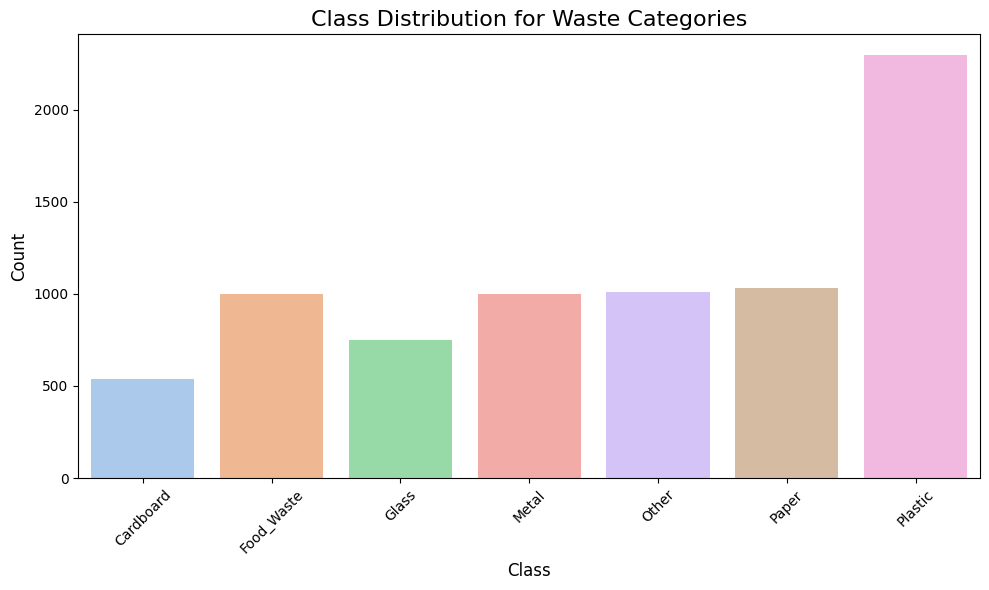

In [12]:
# Count the labels
label_counts = Counter(labels)  # Note: Ensure 'labels' is correctly spelled (was 'lables' in your code)
# Visualise Data Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), hue=list(label_counts.keys()), palette="pastel", legend=False)
plt.title("Class Distribution for Waste Categories", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

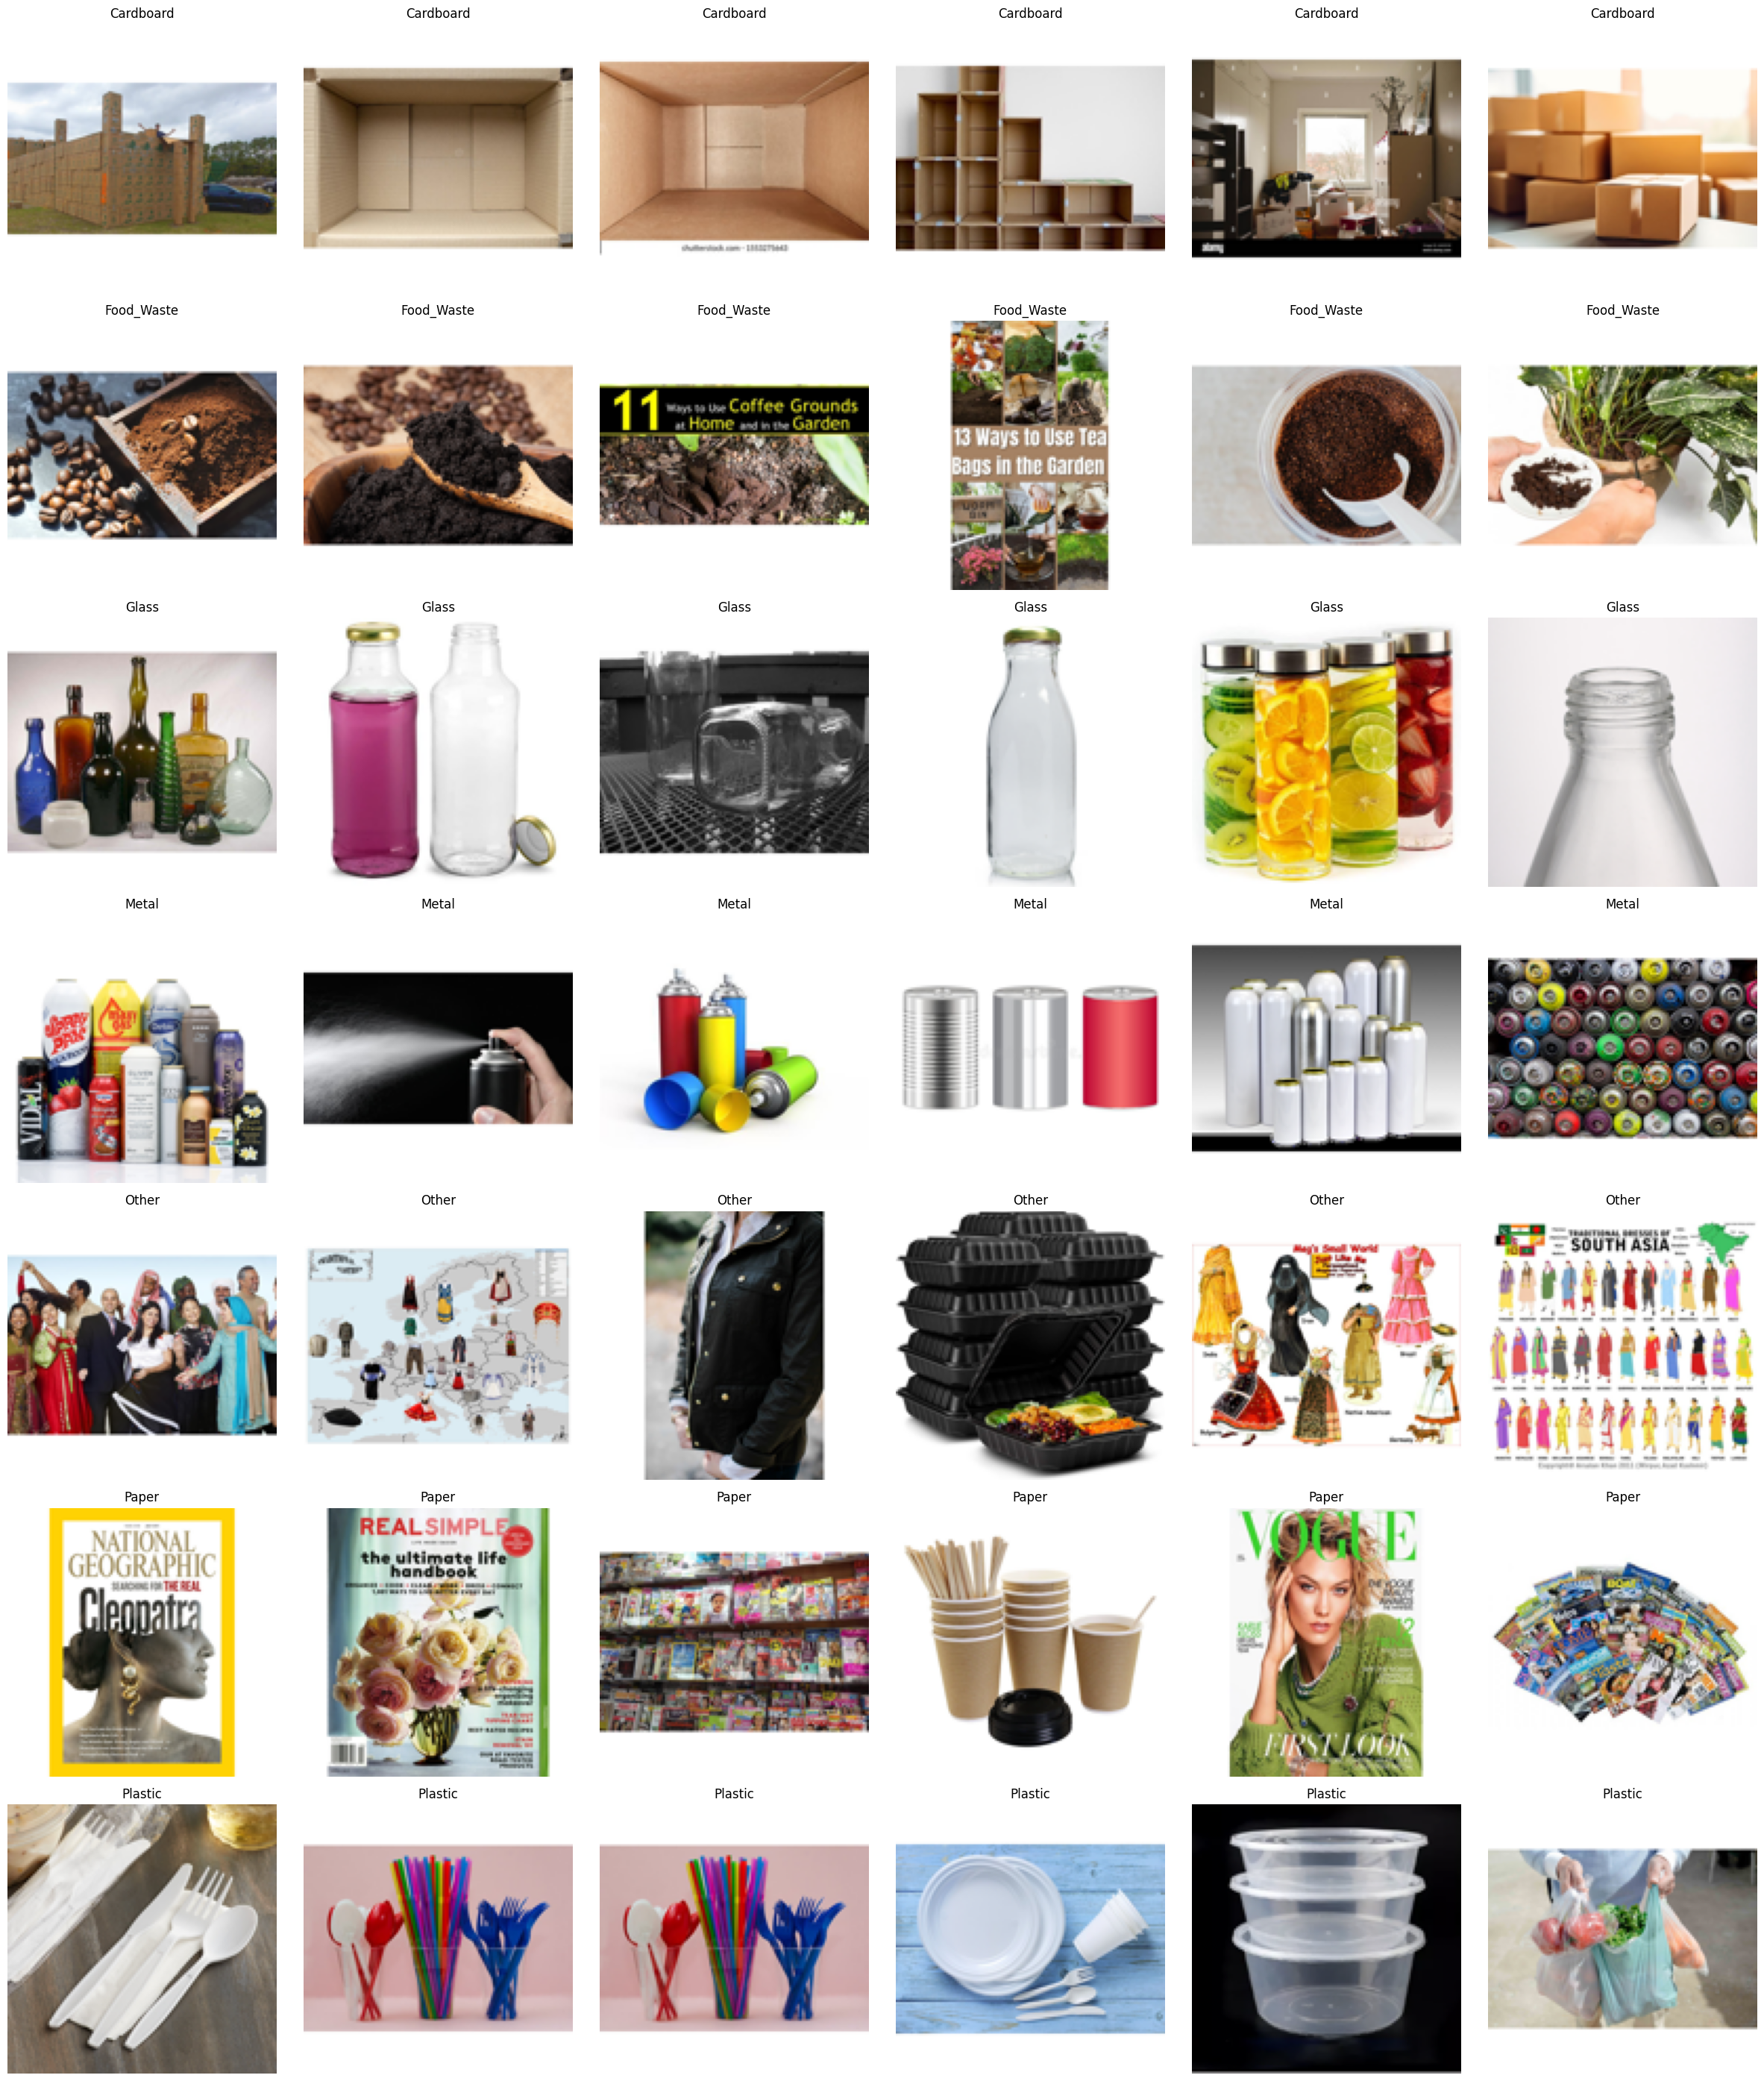

In [13]:
# Visualise Sample Images (across different labels)

# Number of images to display
num_images_to_display = 6

# Dictionary to store the images and labels
images_dict = {}

# Loop through each label and get the first few images
for category_folder in os.listdir(data_path):
    category_path = os.path.join(data_path, category_folder)
    if os.path.isdir(category_path):
        images_dict[category_folder] = []
        for filename in os.listdir(category_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(category_path, filename)
                img = Image.open(img_path)
                img = img.resize((128, 128))  # Resize image to 128x128
                images_dict[category_folder].append(np.array(img))
                if len(images_dict[category_folder]) >= num_images_to_display:
                    break

# Plot the images
plt.figure(figsize=(num_images_to_display * 4, len(images_dict) * 4))
for i, (label, imgs) in enumerate(images_dict.items()):
    for j, img in enumerate(imgs):
        plt.subplot(len(images_dict), num_images_to_display, i * num_images_to_display + j + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
plt.tight_layout()
plt.show()


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [14]:


# Identify the smallest and largest image dimensions in a dataset
# This function scans all images in the dataset, calculates their dimensions,
# and returns the minimum and maximum width and height.

def find_image_dimensions(dataset_directory):
    """
    Determine the smallest and largest dimensions of images in the dataset.

    Args:
        dataset_directory (str): Path to the root directory containing category folders with images.

    Returns:
        tuple: Two tuples containing (smallest_width, smallest_height) and (largest_width, largest_height).
    """
    # Initialize variables to track smallest and largest dimensions
    smallest_width = float('inf')
    smallest_height = float('inf')
    largest_width = 0
    largest_height = 0

    # Iterate through each category folder in the dataset
    for category_name in os.listdir(dataset_directory):
        category_path = os.path.join(dataset_directory, category_name)

        # Process only if the path is a directory
        if os.path.isdir(category_path):
            # Iterate through each file in the category folder
            for image_name in os.listdir(category_path):
                # Check for supported image formats
                if image_name.lower().endswith(('.jpg', '.png')):
                    image_path = os.path.join(category_path, image_name)

                    # Open image and retrieve dimensions
                    with Image.open(image_path) as image:
                        current_width, current_height = image.size

                        # Update smallest dimensions
                        smallest_width = min(smallest_width, current_width)
                        smallest_height = min(smallest_height, current_height)

                        # Update largest dimensions
                        largest_width = max(largest_width, current_width)
                        largest_height = max(largest_height, current_height)

    # Return tuples of smallest and largest dimensions
    return (smallest_width, smallest_height), (largest_width, largest_height)

In [15]:
# Call the function and print the results
min_dimensions, max_dimensions = find_image_dimensions(data_path)
print(f"Smallest dimensions: {min_dimensions}")
print(f"Largest dimensions: {max_dimensions}")

Smallest dimensions: (256, 256)
Largest dimensions: (256, 256)


In [16]:
import os
from PIL import Image

# Scale images to a uniform size

# Function to resize images to a specified resolution
def resize_images(source_dir, destination_dir, target_dimensions=(128, 128)):
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Loop through each category in the source directory
    for class_dir in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_dir)
        class_destination_path = os.path.join(destination_dir, class_dir)

        # Verify if the path is a directory
        if os.path.isdir(class_source_path):
            # Create category-specific destination directory if needed
            if not os.path.exists(class_destination_path):
                os.makedirs(class_destination_path)

            # Process each image in the category
            for image_file in os.listdir(class_source_path):
                if image_file.endswith('.jpg') or image_file.endswith('.png'):
                    source_image_path = os.path.join(class_source_path, image_file)
                    destination_image_path = os.path.join(class_destination_path, image_file)

                    # Load, resize, and save the image
                    with Image.open(source_image_path) as image_obj:
                        scaled_image = image_obj.resize(target_dimensions)
                        scaled_image.save(destination_image_path)

    print(f"Images successfully scaled and saved to {destination_dir}")

In [17]:
# Call the function to resize images
output_path = os.path.join(extract_path, 'resized_data')
resize_images(data_path, output_path, target_dimensions=(128, 128))

Images successfully scaled and saved to DataSet_waste_segregation\resized_data


In [18]:
# Get resized images and their labels
images, labels = load_images(output_path)
print(f"Loaded {len(images)} images with labels.")

Loaded 7625 images with labels.


In [19]:
print(f"Resized images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Resized images shape: (7625, 128, 128, 3)
Labels shape: (7625,)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [20]:
# Encode the labels suitably
unique_labels, encoded_labels = np.unique(labels, return_inverse=True)

# Convert to one-hot encoding
one_hot_labels = to_categorical(encoded_labels)

# Print the results
print("Unique Labels:", unique_labels)
print("Encoded Labels:", encoded_labels)
print("One-Hot Encoded Labels:\n", one_hot_labels)




Unique Labels: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
Encoded Labels: [0 0 0 ... 6 6 6]
One-Hot Encoded Labels:
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [21]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_val, y_train, y_val = train_test_split(images, one_hot_labels, test_size=0.2, stratify=labels, random_state=42)


# Print the shapes of the training and validation sets
print(f"Training set shape: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Validation set shape: X_val shape = {X_val.shape}, y_val shape = {y_val.shape}")



Training set shape: X_train shape = (6100, 128, 128, 3), y_train shape = (6100, 7)
Validation set shape: X_val shape = (1525, 128, 128, 3), y_val shape = (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [22]:
# Construct and configure a convolutional neural network model
# This function builds a CNN with multiple convolutional and dense layers,
# applies batch normalization and dropout for regularization, and compiles the model.

# Define input dimensions and number of output classes
image_dimensions = X_train.shape[1:]  # Dimensions of input images (128, 128, 3)
class_count = y_train.shape[1]  # Number of output classes (one-hot encoded)

# Initialize the sequential model
cnn_model = Sequential()

cnn_model.add(Input(shape=image_dimensions))

# First Convolutional Block
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())  # Normalize activations to stabilize training
cnn_model.add(MaxPooling2D((2, 2)))  # Downsample feature maps

# Second Convolutional Block
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())  # Normalize activations
cnn_model.add(MaxPooling2D((2, 2)))  # Reduce spatial dimensions

# Third Convolutional Block
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())  # Normalize activations
cnn_model.add(MaxPooling2D((2, 2)))  # Further downsample
cnn_model.add(Dropout(0.25))  # Prevent overfitting by randomly dropping units

# Flatten layer to transition to dense layers
cnn_model.add(Flatten())

# First Dense Block
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(BatchNormalization())  # Normalize dense layer activations
cnn_model.add(Dropout(0.5))  # Apply dropout for regularization

# Second Dense Block
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(BatchNormalization())  # Normalize dense layer activations
cnn_model.add(Dropout(0.5))  # Apply dropout for regularization

# Output Layer
cnn_model.add(Dense(class_count, activation='softmax'))  # Output layer for classification

# Configure the model for training
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,075,911 (49.88 MB)

 Trainable params: 13,073,927 (49.87 MB)

 Non-trainable params: 1,984 (7.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [23]:
# Training

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = cnn_model.fit(
    X_train / 255.0,  # Normalize the images to [0, 1]
    y_train,
    validation_data=(X_val / 255.0, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.2824 - loss: 2.4840
Epoch 1: val_loss improved from inf to 2.04066, saving model to best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 114s 583ms/step - accuracy: 0.2826 - loss: 2.4824 - val_accuracy: 0.1731 - val_loss: 2.0407 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.3978 - loss: 1.7452
Epoch 2: val_loss improved from 2.04066 to 1.81672, saving model to best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 108s 566ms/step - accuracy: 0.3978 - loss: 1.7451 - val_accuracy: 0.3449 - val_loss: 1.8167 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.4554 - loss: 1.5260
Epoch 3: val_loss improved from 1.81672 to 1.47021, saving model to best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 108s 566ms/step - accuracy: 0.4555 - loss: 1.5258 - val_accuracy: 0.4728 - val_loss: 1.4702 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/s

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step
Classification Report for Validation Set:
              precision    recall  f1-score   support

   Cardboard       0.72      0.90      0.80       108
  Food_Waste       0.62      0.74      0.67       200
       Glass       0.62      0.56      0.59       150
       Metal       0.82      0.60      0.69       200
       Other       0.62      0.46      0.52       202
       Paper       0.75      0.49      0.59       206
     Plastic       0.64      0.82      0.72       459

    accuracy                           0.67      1525
   macro avg       0.69      0.65      0.66      1525
weighted avg       0.68      0.67      0.66      1525



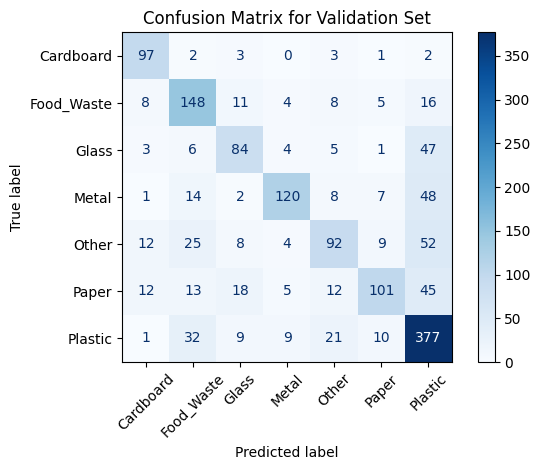

In [24]:
# Evaluate on the test set; display suitable metrics

# Normalize X_val for evaluation
X_val_normalized = X_val / 255.0

# Evaluate the model on the validation set
y_pred = cnn_model.predict(X_val_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification Report for validation set
print("Classification Report for Validation Set:")
print(classification_report(y_true_classes, y_pred_classes, target_names=unique_labels))

# Confusion Matrix for validation set
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=np.arange(class_count))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Validation Set")
plt.tight_layout()
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [25]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [26]:
# Create a function to augment the images




In [27]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [28]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

In [29]:
# Calculate accuracy
accu_score = accuracy_score(y_true_classes, y_pred_classes)
# Calculate precision, recall, and F1 score
precision_score = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall_score = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1_score = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accu_score:.4f}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.6682
Precision: 0.6780
Recall: 0.6682
F1 Score: 0.6606


<h2>Insights on the Dataset</h2>

<h3>Dataset Overview</h3>
<ul>
  <li>The dataset contains images categorized into <strong>seven unique classes</strong>: 
    <code>Cardboard</code>, <code>Food_Waste</code>, <code>Glass</code>, 
    <code>Metal</code>, <code>Paper</code>, <code>Plastic</code>, and <code>Other</code>.
  </li>
  <li>Each category is organized in its own folder with images corresponding to that specific type of waste.</li>
</ul>

<h3>Distribution of Classes</h3>
<ul>
  <li>The dataset reveals a <strong>class imbalance</strong>, which is apparent in the visualization of class frequencies.</li>
  <li>The <code>Plastic</code> class has the <strong>most samples</strong> (2,295), whereas <code>Cardboard</code> contains the <strong>least</strong> (540).</li>
  <li>This uneven distribution might result in <strong>biased model predictions</strong> toward the more frequent classes.</li>
</ul>

<h3>Image Properties</h3>
<ul>
  <li>All files are in the <strong><code>.png</code> format</strong>.</li>
  <li>Images were resized to a standardized dimension of <strong>128×128 pixels</strong> to ensure uniformity for model input.</li>
</ul>

<h3>Encoding Labels</h3>
<ul>
  <li>Labels were <strong>extracted from directory names</strong> and then <strong>converted into numerical values</strong>.</li>
  <li>To enable multiclass classification, <strong>one-hot encoding</strong> was applied to these numeric labels.</li>
</ul>

<h3>Data Partitioning</h3>
<ul>
  <li>The dataset was divided into <strong>training and validation subsets</strong> following an <strong>80:20 split</strong>.</li>
  <li><strong>Stratified sampling</strong> was used to preserve the class proportion in both subsets.</li>
</ul>

<h3>Anticipated Challenges</h3>
<ul>
  <li>The <strong>imbalance among categories</strong> could impact model fairness and performance. Possible mitigation strategies include:
    <ul>
      <li>Applying data augmentation techniques</li>
      <li>Using class weights during training</li>
      <li>Employing over- or under-sampling methods</li>
    </ul>
  </li>
  <li><strong>Similarities in visual features</strong> across certain categories may make classification more difficult, necessitating more advanced models or improved feature extraction methods.</li>
</ul>
